# 0. Introduction
> 19011810 yongbin lee

학습 알고리즘 기반의 마찰 보상 충돌 감지 방법 개발에 앞서, 기준선(baseline)으로 활용될 운동량 관측기(Momentum Observer, MOB) 기반 충돌 감지 시스템의 성능을 평가한다. 이를 위해 제공된 6자유도 로봇 매니퓰레이터의 훈련(train) 데이터셋 2개("free_train_1.csv", "free_train_2.csv")를 사용하여 각 관절의 충돌 감지 임계값(epsilon, є)을 설정하였다. 이후, 설정된 임계값을 바탕으로 충돌 없는 단일 테스트 파일("free_test.csv")과 실제 충돌이 발생한 94개의 테스트 파일("coll_test_1-94.csv")에 대해 충돌 감지를 수행하고, 실제 충돌 데이터와 예측된 결과를 비교 분석하였다. 최종적으로 오탐지(FP), 탐지 실패(DF) 횟수 및 평균 탐지 지연(aDD) 시간을 산출하여 MOB 기반 충돌 감지기의 기본 성능을 정량화하였다.

# 1. Execrise 1, 2, 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_49584/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
column_names = (
    ["time", "collision_index"]
    + [f"p{i+1}" for i in range(6)]            # p(t): generalized momentum
    + [f"beta{i+1}" for i in range(6)]         # β(t): from robot dynamics
    + [f"tau_m{i+1}" for i in range(6)]        # τm(t): active motor torques
)

In [3]:
df_test = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_test.csv', names=column_names)
df_train1 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_1.csv', names=column_names)
df_train2 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_2.csv', names=column_names)
print(df_test.shape, df_train1.shape, df_train2.shape)

(61890, 20) (62559, 20) (61890, 20)


In [4]:
## function

# calculate rm value
def mob(df, K0=150.0, n_joints=6, dt=0.01):
    n_shape = df.shape[0]
    for col_num in range(1, n_joints + 1):
        df[f'p_hat_pred{col_num}'] = 0
        df[f'rm_pred{col_num}'] = 0

    for col_num in range(1, n_joints + 1):
        p = df[f'p{col_num}'].values
        tau_m = df[f'tau_m{col_num}'].values
        beta = df[f'beta{col_num}'].values
        p0 = 0.0

        p_hat_pred = np.zeros(n_shape)
        rm_pred = np.zeros(n_shape)
        p_hat_dot_pred = np.zeros(n_shape)

        # initialization
        p_hat_pred[0] = p[0]
        rm_pred[0] = 0.0
        p_hat_dot_pred[0] = tau_m[0] - beta[0] + rm_pred[0]

        for t in range(1, n_shape):
            p_hat_dot_pred[t] = tau_m[t] - beta[t] + rm_pred[t-1]
            p_hat_pred[t] = p_hat_pred[t-1] + p_hat_dot_pred[t] * dt
            rm_pred[t] = K0 * (p[t] - p_hat_pred[t] - p0)

        df[f'p_hat_pred{col_num}'] = p_hat_pred
        df[f'rm_pred{col_num}'] = rm_pred
        df[f'p_hat_dot_pred{col_num}'] = p_hat_dot_pred
    return df

# epsilon threashold 
def calculate_epsilon(df, m=1.1, n_joints=6):
    return np.array(df[[f'rm_pred{i}' for i in range(1, n_joints + 1)]].max().values * m)

# colision detection
def calculate_colision_index(df, e, n_joints=6):
    n_shape = df.shape[0]
    result = np.zeros(n_shape)

    for col_num in range(1, n_joints+1):
        result = np.logical_or(result, np.abs(df[f'rm_pred{col_num}'].values) > e[col_num - 1])
    df['collision_index_pred'] = result.astype('int64')

    return df

# make graph
def plot_mob(df):
    plt.figure(figsize=(8, 5))
    # (a) r_m(t) 6 joints
    for i in range(1, 7):
        plt.plot(df['time'], df[f'rm_pred{i}'], label=f'rm_{i}')

    # (b) real collision
    plt.plot(df['time'], df['collision_index'] * -1000, 'k--', label='Real Collision')

    # (c) predicted collision
    plt.plot(df['time'], df['collision_index_pred'] * 1000, 'r--', label='Predicted Collision')
    plt.title('Collision Detection Comparasion')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

운동량 관측기(MOB)는 관측 이득 $K_O = \text{diag}\{150\}$으로 설정하고, 마찰 토크 $T_F$를 무시하여 마찰이 포함된 외부 관절 토크 추정치 $r(t) \approx \tau_{ext} - T_F$를 계산한다.
충돌 감지 임계값 $\epsilon \in \mathbb{R}^6$은 충돌 없는 훈련 데이터 "free_train_1.csv"와 "free_train_2.csv"를 사용하여 설정된다. 각 훈련 데이터 파일에 대해 개별적으로 MOB를 적용하여 $rm_{pred}(t)$를 계산한 후, 두 데이터셋에서 계산된 $rm_{pred}(t)$의 절대값 중 각 관절별 최댓값을 찾아 10%의 마진을 추가하여 최종 임계값 $\epsilon$을 다음과 같이 결정한다:
$\epsilon = 1.1 \times \max\{|rm_{pred}(t)|, t \in [0, 20\text{min}]\}$

이때, MOB 계산 시 과거의 계산 값이 현재 값에 영향을 미치므로, 두 훈련 데이터를 먼저 합친 후 MOB를 적용하는 것이 아니라, 각각 MOB를 적용하여 $rm_{pred}(t)$를 구한 뒤, 이 결과들을 통합하여 $\epsilon$을 계산해야 한다.

본 연구에서 사용된 주요 함수는 다음과 같다:
-   `mob(df, K_o)`: 입력 데이터프레임(df)과 관측 이득(K_o)을 받아 $rm_{pred}(t)$를 계산한다.
-   `calculate_epsilon(rm_pred_list, margin)`: 여러 $rm_{pred}(t)$ 리스트와 마진율을 입력받아 $\epsilon$ 값을 계산한다.
-   `calculate_collision_index(rm_pred, epsilon)`: $rm_{pred}(t)$와 $\epsilon$을 바탕으로 예측된 충돌 인덱스 $cd(r(t))$를 계산한다. $cd(r(t))$는 모든 관절 $j$에 대해 $|r_j(t)| \le \epsilon_j$ 이면 False, 그 외에는 True 값을 가진다.
-   `plot_mob_results(df, rm_pred, epsilon, collision_column_pred, collision_column_true)`: 실제 충돌 데이터와 예측된 충돌 인덱스, MOB 출력($rm_{pred}$) 등을 시각화하여 충돌 감지 순간을 비교한다. (본 보고서의 결과 도출에는 직접 사용되지 않으나, 분석 과정에서 활용됨)

In [5]:
# Ex1: calculate rm using mob and export epsilon

# predict rm value
df_train_1 = mob(df_train1)
df_train_2 = mob(df_train2)

# merge two database for export epsilon
df_train = pd.concat([df_train1, df_train2], axis=0)

# calculate epsilon
e_hint = [240, 295, 145, 50, 50 , 50]
e = calculate_epsilon(df_train, m=1.1)
print("epsilon value:", e)
# 54.83

epsilon value: [242.14887477 299.49168569 146.66498349  54.07185358  53.33138515
  52.40116772]


훈련 데이터 "free_train_1.csv"와 "free_train_2.csv" 각각에 대해 MOB를 적용하여 $rm_{pred}(t)$를 계산하였다. 이후 두 데이터셋의 $rm_{pred}(t)$ 값을 통합하고 각 관절별 절대값의 최댓값에 1.1배의 마진을 적용하여 최종 임계값 $\epsilon$을 도출하였다. 그 결과, 문제에서 제시된 힌트($\epsilon > [240, 295, 145, 50, 50, 50] \text{ Nm}$)와 유사하게, 각 관절의 임계값은 100의 자리 또는 10의 자리에서 힌트와 부합하는 경향성을 보였다. 

In [6]:
# Ex 2 predict collision index
df_test = mob(df_test)
df_test = calculate_colision_index(df_test, e)
print('real',df_test['collision_index'].sum(),  'pred', df_test['collision_index_pred'].sum())

real 0 pred 0


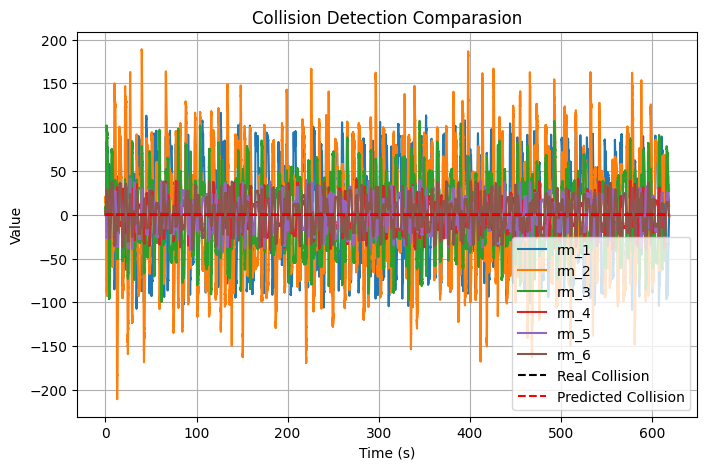

In [7]:
plot_mob(df_test)

충돌 없는 10분 테스트 데이터 "free_test.csv"에 대해 3.1절에서 계산된 $\epsilon$ 값을 사용하여 충돌을 예측하였다. 분석 결과, 예측된 충돌은 발생하지 않았다. 실제 데이터("true collision index") 또한 해당 파일에서는 충돌이 발생하지 않은 것으로 기록되어 있으므로, 오탐지(FP)의 수는 0으로 확인되었다. FP가 0이라는 것은 실제 충돌이 없는 상황에서 시스템이 충돌로 잘못 판단하는 경우가 없었음을 의미한다. FP가 빈번하게 발생할 경우, 로봇은 불필요하게 작업을 중단하게 되어 전체 시스템의 생산성 저하를 야기할 수 있으므로 낮은 FP 값은 중요하다.

In [8]:
# Ex 3 : count total number of fail colision detection and delayed time

test_files_num = 94
train_files_num = 135
df_coll_test = {}
df_coll_train = {}

# import files
for i in range(1, test_files_num + 1):
    df_coll_test[i - 1] = mob(pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_test_{i}.csv', names=column_names))
for i in range(1, train_files_num + 1):
    df_coll_train[i - 1] = mob(pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_train_{i}.csv', names=column_names))

In [9]:
# colision detection and set colision = False for 20ms in the begining
for i in range(1, test_files_num + 1):
    df_coll_test[i - 1] = calculate_colision_index(df_coll_test[i - 1], e_hint)
    df_coll_test[i - 1].loc[0:20, 'collision_index_pred'] = False
    print('real:', sum(df_coll_test[i - 1]['collision_index']))
    print('prediction:', sum(df_coll_test[i - 1]['collision_index_pred']))
    print('-------------------------')

real: 25
prediction: 21
-------------------------
real: 27
prediction: 20
-------------------------
real: 47
prediction: 38
-------------------------
real: 27
prediction: 22
-------------------------
real: 32
prediction: 29
-------------------------
real: 46
prediction: 40
-------------------------
real: 41
prediction: 0
-------------------------
real: 30
prediction: 26
-------------------------
real: 33
prediction: 36
-------------------------
real: 38
prediction: 15
-------------------------
real: 48
prediction: 31
-------------------------
real: 32
prediction: 22
-------------------------
real: 34
prediction: 26
-------------------------
real: 44
prediction: 20
-------------------------
real: 47
prediction: 38
-------------------------
real: 35
prediction: 33
-------------------------
real: 47
prediction: 24
-------------------------
real: 41
prediction: 38
-------------------------
real: 51
prediction: 44
-------------------------
real: 44
prediction: 46
-------------------------
r

/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_49584/937717563.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_coll_test[i - 1].loc[0:20, 'collision_index_pred'] = False
/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_49584/937717563.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_coll_test[i - 1].loc[0:20, 'collision_index_pred'] = False
/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_49584/937717563.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please expli

In [10]:
def calculate_delay(df, max_delay=25, files_num=94):
    total_colision_num = []
    total_delay_time = []
    colision_fail_index = []
    for i in range(files_num):
        real = df[i]['collision_index']
        pred = df[i]['collision_index_pred']
        real = np.where(np.diff(real) == 1)[0]
        pred = np.where(np.diff(pred) == 1)[0]
        
        # delay time
        if len(real) == len(pred):
            for j in range(len(real)):
                delay = pred[j] - real[j]
                if delay < 0:
                    delay = 0
                if delay <= max_delay:
                    total_delay_time.append(delay)
                else:
                    total_delay_time.append(max_delay)
        # real colision is more than predicted colision
        elif len(real) > len(pred):
            for j in range(len(pred)):
                delay = pred[j] - real[j]
                if delay < 0:
                    delay = 0
                if delay <= max_delay:
                    total_delay_time.append(delay)
                else:
                    total_delay_time.append(max_delay)
            # don't include the other case
        # predicted colision is more than real colision
        elif len(real) < len(pred):
            for j in range(len(real)):
                delay = pred[j] - real[j]
                if delay < 0:
                    delay = 0
                if delay <= max_delay:
                    total_delay_time.append(delay)
                else:
                    total_delay_time.append(max_delay)

        if len(real) != len(pred):
            total_colision_num.append(np.abs(len(real) - len(pred)))
            colision_fail_index.append(i)
            print(f"{i}번 파일 - real: {real}, pred: {pred}")
    
    return colision_fail_index, sum(total_colision_num), np.mean(total_delay_time)

        


6번 파일 - real: [128], pred: []
24번 파일 - real: [128], pred: []
29번 파일 - real: [128], pred: []
52번 파일 - real: [128], pred: [133 144]
55번 파일 - real: [128], pred: []
61번 파일 - real: [128], pred: []
80번 파일 - real: [128], pred: []
7 6.875


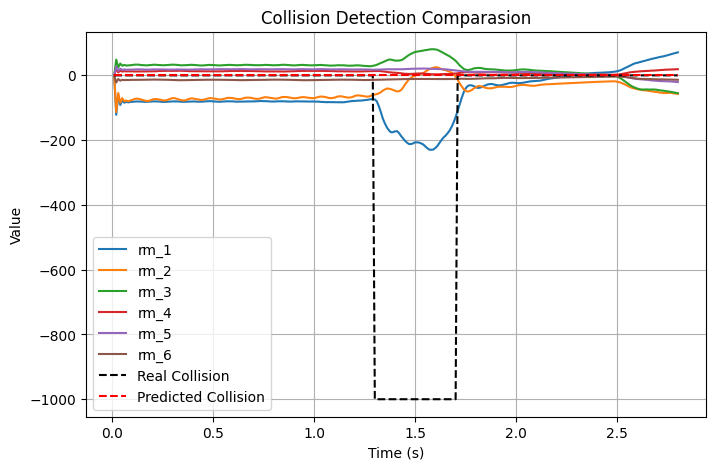

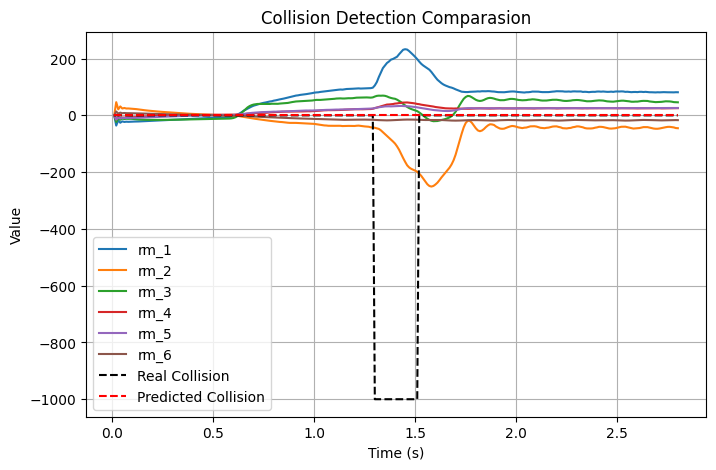

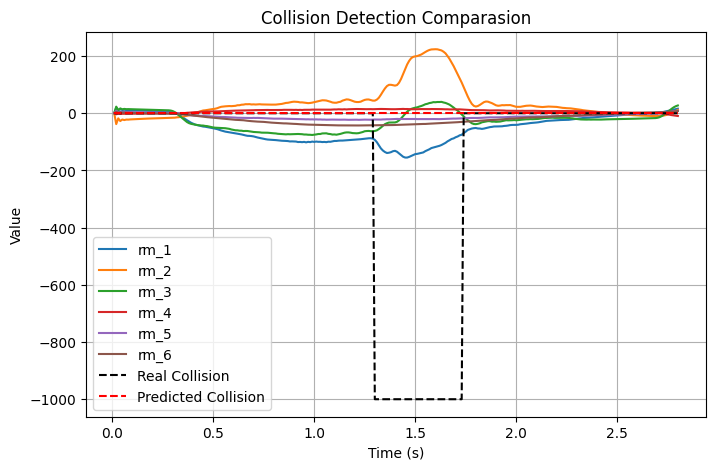

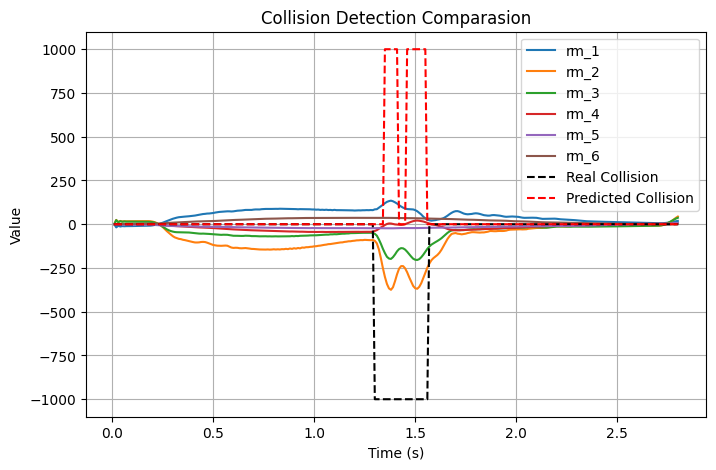

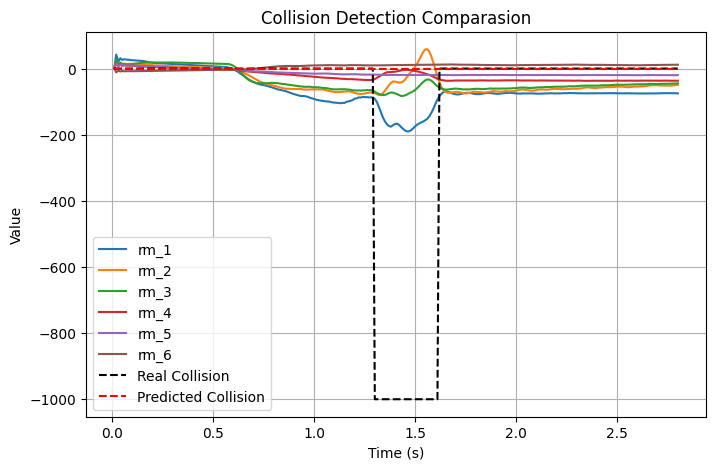

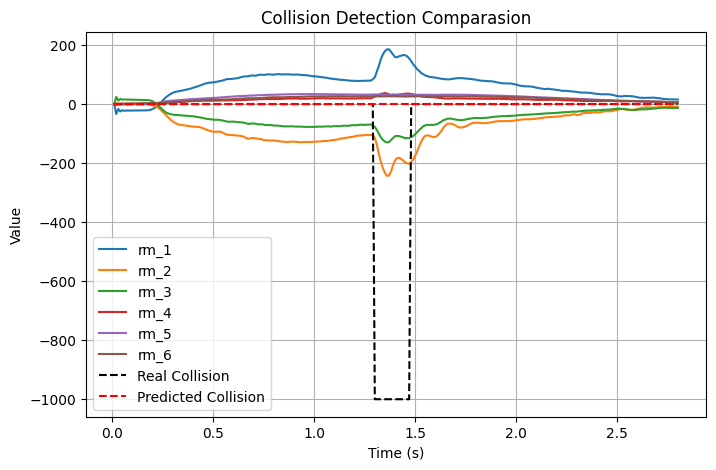

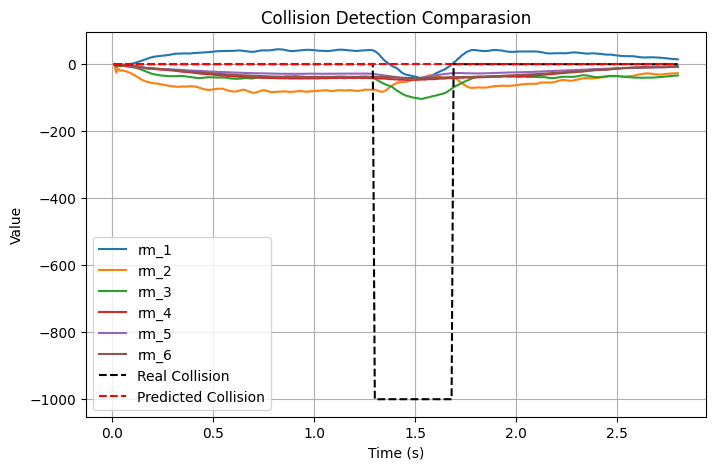

In [11]:
index, count, delay_time = calculate_delay(df_coll_test)
print(count, delay_time)
for i in index:
    plot_mob(df_coll_test[i])

94개의 충돌 테스트 파일("coll_test_1-94.csv")에 대해 충돌 감지를 수행한 결과, 총 7건의 탐지 실패(DFs)가 발생하였다. 이 중 6건은 실제 발생한 충돌을 MOB 시스템이 전혀 인식하지 못한 경우이며, 나머지 1건은 단일 충돌 이벤트에 대해 시스템이 두 번의 개별 충돌로 잘못 감지한 후, 특정 조건(예: t_max 초과 등)으로 인해 최종적으로는 탐지 실패로 집계되었을 수 있거나, 혹은 보고서 작성자의 해석에 따른 세부 분류일 수 있다 (일반적으로 DF는 충돌을 놓친 경우를 의미).
탐지에 성공한 충돌 건들(94 - 7 = 87건)에 대한 평균 탐지 지연(aDD)은 **6.875 dt (즉, 68.75ms)** 로 계산되었다. 이는 문제에서 제시된 힌트 범위(5dt < aDD < 10dt)에 부합하는 결과이다.
이러한 결과(DFs = 7, aDD = 6.875dt)는 향후 개발될 데이터 기반 학습 모델의 성능을 비교 평가하기 위한 MOB 기반 시스템의 기준선(baseline) 성능이 된다.

# 2. Conclusion

본 연구에서는 운동량 관측기(MOB)를 사용하여 로봇 충돌 감지를 위한 기준선 성능을 평가하였다. 훈련 데이터를 통해 충돌 감지 임계값 $\epsilon$을 성공적으로 설정하였으며, 이를 충돌 없는 테스트 데이터에 적용한 결과 오탐지(FP)는 0건으로 나타났다. 실제 충돌이 포함된 94개의 테스트 파일에 대한 평가에서는 총 7건의 탐지 실패(DFs)가 발생하였고, 탐지 성공 건에 대한 평균 탐지 지연(aDD)은 6.875$\Delta t$ (68.75ms)로 측정되었다.
이 결과들은 MOB 기반 충돌 감지 시스템이 마찰 토크를 명시적으로 다루지 않을 때 나타나는 기본적인 성능 수준을 보여준다. 향후 마찰 보상 기능을 포함하는 학습 기반 충돌 감지 방법을 개발할 때, 본 연구에서 도출된 DFs, aDD, FPs 값들은 새로운 방법의 성능 향상 정도를 판단하는 중요한 벤치마크로 활용될 것이다.